In [1]:
import os
from natsort import natsorted
import pydicom
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize
import pandas as pd

In [2]:
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border

In [3]:
import SimpleITK as sitk
def getPixelDataWithSitk(patient_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(patient_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return sitk.GetArrayFromImage(image)


In [4]:
base = 'data/train/'
# base = 'data/test/'
# base = '/data/bigdata/kaggle/input/osic-pulmonary-fibrosis-progression/train/'Type a message
path_to_save = 'out_plots/'

In [190]:
def regression(df):
    #fit function:
        #y=ax+b
    
    x = df['Weeks']
    y = df['FVC']
    
    # test if data contains more atleast 2 points
    if len(x) < 2:
        return np.nan
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
    a, b = np.polyfit(x, y, 1) # degree 1 = linear regression
    c=np.sqrt(2)*np.abs(x*a+b-y).sum()/len(x)
    
    return a, b, c

In [205]:
tr=pd.read_csv('data/train.csv')
tr['a']=np.nan
tr['b']=np.nan
tr['c']=np.nan
tr

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,a,b,c
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,NaN,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,NaN,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,NaN,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,NaN,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,NaN,NaN,NaN
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,NaN,NaN,NaN
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,NaN,NaN,NaN
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,NaN,NaN,NaN


In [206]:
group_by_patient = tr.groupby(by='Patient')

In [207]:
fit_result = group_by_patient.apply(regression)

In [316]:
fit_result

Patient
ID00007637202177411956430    (-3.1671258700695906, 2174.4161832946634, 83.5...
ID00009637202177434476278    (-9.379955123410666, 3821.785589628522, 109.46...
ID00010637202177584971671    (-17.042803238739097, 3311.68960773524, 189.49...
ID00011637202177653955184    (-4.548925129725749, 3487.076352853967, 91.360...
ID00012637202177665765362    (-8.543078528986687, 3774.033242331781, 148.21...
                                                   ...                        
ID00419637202311204720264    (-2.1359750738995746, 2828.8501238315894, 103....
ID00421637202311550012437    (-1.5540298934420225, 2814.7896731745677, 69.8...
ID00422637202311677017371    (-4.740104413858565, 1984.8246796392968, 52.46...
ID00423637202312137826377    (-9.214885618301052, 3049.99572068469, 231.199...
ID00426637202313170790466    (-1.0813172043010562, 2919.4014336917567, 89.1...
Length: 176, dtype: object

In [209]:
for patient in fit_result.index:
    a,b,c=fit_result[fit_result.index==patient].values[0]
    tr.loc[tr.Patient==patient,['a', 'b', 'c']]=fit_result[patient]

In [309]:
train_df = tr.drop_duplicates(['Patient'])

In [433]:
train_df = train_df[train_df.Patient.isin(spacing_dict.keys())]

In [434]:
train_df.to_csv('data/train_df.csv', index=False)

In [314]:
spacing_dict.keys()

dict_keys(['ID00170637202238079193844', 'ID00319637202283897208687', 'ID00104637202208063407045', 'ID00381637202299644114027', 'ID00407637202308788732304', 'ID00222637202259066229764', 'ID00219637202258203123958', 'ID00180637202240177410333', 'ID00351637202289476567312', 'ID00207637202252526380974', 'ID00331637202286306023714', 'ID00228637202259965313869', 'ID00183637202241995351650', 'ID00130637202220059448013', 'ID00288637202279148973731', 'ID00015637202177877247924', 'ID00422637202311677017371', 'ID00221637202258717315571', 'ID00136637202224951350618', 'ID00218637202258156844710', 'ID00167637202237397919352', 'ID00343637202287577133798', 'ID00047637202184938901501', 'ID00383637202300493233675', 'ID00068637202190879923934', 'ID00131637202220424084844', 'ID00249637202266730854017', 'ID00419637202311204720264', 'ID00339637202287377736231', 'ID00355637202295106567614', 'ID00335637202286784464927', 'ID00082637202201836229724', 'ID00234637202261078001846', 'ID00264637202270643353440', 'ID

In [94]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices



def get_spacing(scan):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing))
    return spacing




def resample(image, spacing, new_spacing=[1,1,1]):
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    image[image < -1000] = -1000
    
    return image


def crop_center(img, crop_x, crop_y, crop_z):
    z,y,x = img.shape
    start_x = x//2-(crop_x//2)
    start_y = y//2-(crop_y//2)
    start_z = z//2-(crop_z//2)
    return img[start_z:start_z+crop_z, start_y:start_y+crop_y, start_x:start_x+crop_x]

In [112]:
spacing_dict = {}
exclusion_list = []
for pacient in tqdm(os.listdir(base)):
    try:
        scan = load_scan(base+pacient)
        if get_spacing(scan)[0] != 0 :
            spacing_dict[pacient] = get_spacing(scan)
        else:
            exclusion_list.append(pacient)
    except:
        exclusion_list.append(pacient)
        

100%|██████████| 176/176 [01:26<00:00,  2.03it/s]


In [232]:
train_df = fit_result[spacing_dict.keys()].reset_index().rename(columns={0: 'label'})

In [234]:
train_df.to_csv('data/train_df.csv', index=False)

In [299]:
a,b,c = train_df.loc[0, 'label']

In [307]:
type(train_df.loc[0, 'label'])

tuple

In [179]:
pacient = 'ID00419637202311204720264'

In [180]:
data = getPixelDataWithSitk(base+pacient)
# data[data<-2000] = 0

In [181]:
scan = load_scan(base+pacient)
spacing = get_spacing(scan)
print(spacing)

[10.        0.820312  0.820312]


In [182]:
data.shape

(28, 1100, 888)

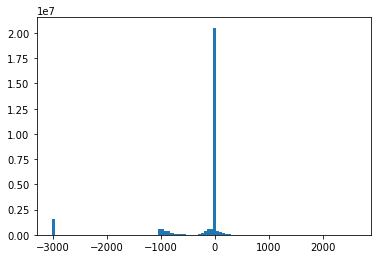

In [183]:
plt.hist(data.reshape(-1), bins=100)
plt.show()

In [184]:
scaled = resample(data, spacing)
scaled_croped = crop_center(scaled, 220, 220, 24)

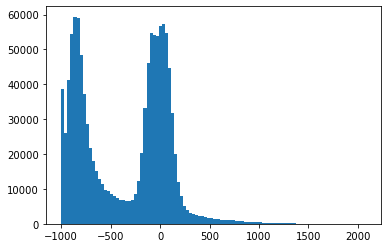

In [185]:
plt.hist(scaled_croped.reshape(-1), bins=100)
plt.show()

In [186]:
data.shape, scaled.shape, scaled_croped.shape

((28, 1100, 888), (280, 902, 728), (24, 220, 220))

In [187]:
rows = 4
colums = 8
pos = np.array(np.split(np.arange(rows*colums)+1, colums))
pos_l = pos[::2].reshape(-1)
pos_r = pos[1::2].reshape(-1)

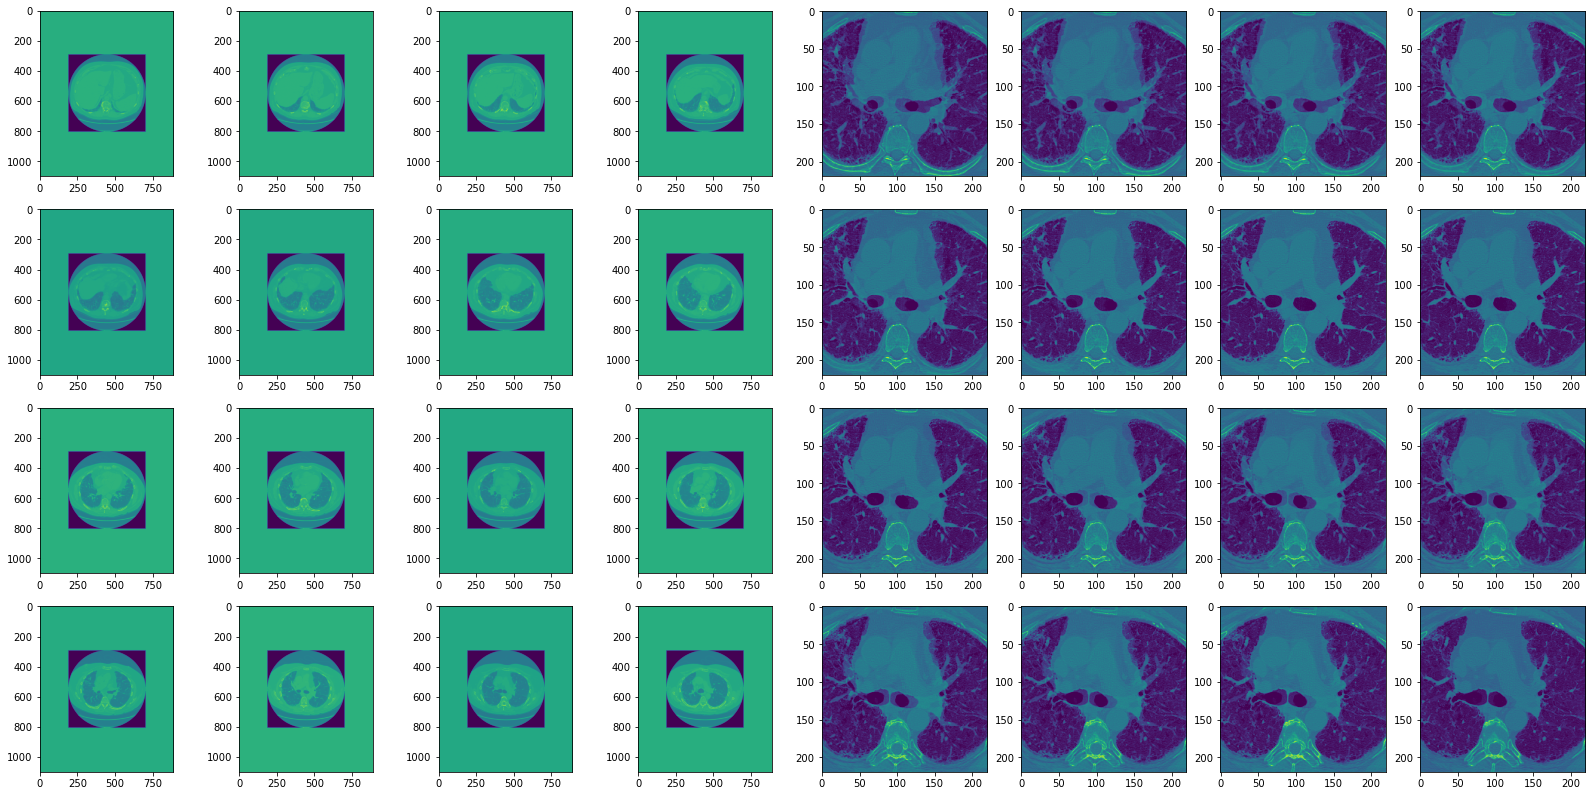

In [188]:
plt.figure(figsize=(28,14))
for i in range(0, 16):
    plt.subplot(4,8, pos_l[i])
    plt.imshow(data[i])
    
    plt.subplot(4,8, pos_r[i])
    plt.imshow((scaled_croped[i]))

plt.show()
    

In [ ]:
exclusion_list_2 = []
for pacient in spacing_dict:
    print(pacient)
    try:
        data = getPixelDataWithSitk(base+pacient)
    except:
        exclusion_list_2.append(pacient)
    image = resample(data, spacing_dict[pacient]) 
    np.save('data/train_transformed/'+pacient+'.npy', image)
    print(data.shape)
    print(image.shape)

In [ ]:
for pacient in spacing_dict:
    image = np.load('data/train_transformed/'+pacient+'.npy')
    image = crop_center(image, 220, 220, 30)
    np.save('data/train_transformed_2/'+pacient+'.npy', image)
    print(pacient, image.shape)

In [16]:
def min_max_scailing(df, column):
    df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
    return df

train_df = pd.read_csv('data/train_df.csv')

train_df = min_max_scailing(train_df, 'a')
train_df = min_max_scailing(train_df, 'b')
train_df = min_max_scailing(train_df, 'c')

train_df[:-10].to_csv('data/train_df_scailed_train.csv', index=False)
train_df[-10:].to_csv('data/train_df_scailed_test.csv', index=False)

# Dataset

In [404]:
import torch
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
import os


class OSICDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
            
        self.meta = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pacient = self.meta.Patient[idx] 
        scan = np.load(self.root_dir+pacient+'.npy')
        
        scan = (scan-scan.min())/(scan.max()-scan.min())
        
        a = self.meta.loc[idx, 'a']
        b = self.meta.loc[idx, 'b']
#         c = self.meta.loc[idx, 'c']
        
        label = np.array([a, b])

        
        sample = {'scan' : scan, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample


# Dataloader

In [405]:
from torch.utils.data import Dataset, DataLoader

In [406]:
train_dataset = OSICDataset('data/train_df_scailed_train.csv', 'data/train_transformed_2/')
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = OSICDataset('data/train_df_scailed_test.csv', 'data/train_transformed_2/')
dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=2)

In [358]:
batch = next(iter(dataloader))

In [359]:
batch['scan'].shape

torch.Size([16, 30, 220, 220])

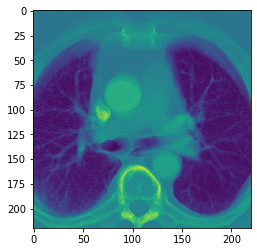

In [360]:
plt.imshow(batch['scan'][2].sum(axis=0))

# Model

In [407]:
import torch
import torch.nn as nn


class OSIC_Model_2d(nn.Module):
    def __init__(self, ngpu):
        super(OSIC_Model_2d, self).__init__()
        self.ngpu = ngpu

        # input shape [3 x 1365 x 2048] going into convolutional
        self.main_conv = nn.Sequential(

            nn.Conv2d(30, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(32, 64, 3, 2, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(128, 128, 3, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )


        # out shape [ 256, 1, 1, 1 ] from convolutional going into fully conected classifier
        self.fc = nn.Sequential(

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(16, 2)
        )

    def forward(self, image):

        conv_out = self.main_conv(image)
        fc_input = conv_out.view(len(conv_out), 256)

        return self.fc(fc_input)
    

class OSIC_Model_3d(nn.Module):
    def __init__(self, ngpu):
        super(OSIC_Model_3d, self).__init__()
        self.ngpu = ngpu

        # input shape [3 x 1365 x 2048] going into convolutional
        self.main_conv = nn.Sequential(

            nn.Conv3d(1, 16, 3, 2, 0, bias=False),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),

            nn.Conv3d(16, 32, 3, 2, 0, bias=False),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),


            nn.Conv3d(32, 64, (2,3,3), (1,2,2), 0, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(64, 128, (2,3,3), (1,2,2), 0, bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(128, 256, (2,3,3), (1,2,2), 0, bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(256, 256, (3,3,3), (1,2,2), 0, bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
            
        )


        # out shape [ 256, 1, 1, 1 ] from convolutional going into fully conected classifier
        self.fc = nn.Sequential(

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 5),
            nn.ReLU(inplace=True),
            
            nn.Linear(5, 2)
        )

    def forward(self, image):

        conv_out = self.main_conv(image)
        fc_input = conv_out.view(len(conv_out), 1024)

        return self.fc(fc_input)
    



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

In [408]:
model = OSIC_Model_3d(1)
model.apply(weights_init)
print(sum(p.numel() for p in model.parameters()))

3252705


In [409]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [410]:
torch.cuda.is_available()

True

In [445]:
model = model.to(torch.device('cpu'))
model = model.eval()

In [446]:
mma = [-28.182574916759147,14.682611731843558]
mmb = [1063.4501144913306, 5919.045454545453] 
mmc = [21.503731194211227, 512.7581483073891]

In [447]:
def norm_back(x,mm,w=1):
    return x*(mm[1]-mm[0])/w+mm[0]

In [451]:
batch = next(iter(dataloader_test))

In [452]:
norm_back(model(batch['scan'].unsqueeze(1).float()), mma)

tensor([[ -5.7265, -13.2327],
        [ -3.2069, -11.5742],
        [ -7.8431, -14.6251],
        [ -3.2835, -11.6250],
        [ -5.3257, -12.9690],
        [ -3.8441, -11.9946],
        [ -2.3411, -11.0051],
        [ -6.0611, -13.4525],
        [ -6.2002, -13.5453],
        [ -2.2905, -10.9713]], grad_fn=<AddBackward0>)

In [453]:
norm_back(batch['label'], mma)

tensor([[-2.1360e+00, -1.2598e+01],
        [-1.5540e+00, -1.2722e+01],
        [-4.5130e+00, -8.7735e+00],
        [-1.1616e+00, -8.0361e+00],
        [-2.0454e+01, -1.1229e+01],
        [-9.2149e+00, -1.0645e+01],
        [-1.0813e+00, -1.1798e+01],
        [-9.5680e-01, -2.2169e+01],
        [-4.7401e+00, -2.0049e+01],
        [ 1.6660e-02, -1.6276e+01]], dtype=torch.float64)

In [412]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [413]:
losses = []
losses_test = []

In [442]:
num_epochs = 5
model = model.to(device)
for epoch in range(num_epochs):
    for batch in tqdm(dataloader):
        model.train()
        optimizer.zero_grad()
        
        scans, labels = batch['scan'].unsqueeze(1).to(device), batch['label'].to(device)

        output = model(scans.float())
        
        loss = criterion(output, labels.float())
        loss.backward()
        optimizer.step()       
        losses.append(loss.item())
        
        for batch in dataloader_test:
            model.eval()
            scans, labels = batch['scan'].unsqueeze(1).to(device), batch['label'].to(device)
            with torch.no_grad():
                output = model(scans.float())
                loss = criterion(output, labels.float())
                losses_test.append(loss.item())


100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


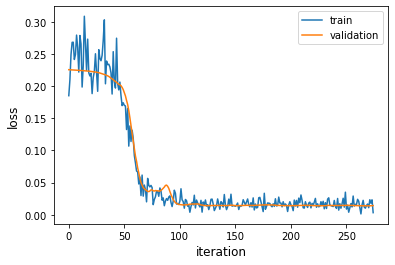

In [457]:
plt.plot(losses, label='train')
plt.plot(losses_test, label='validation')
plt.xlabel('iteration', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.show()

In [444]:
losses_test[-1]

0.01427912712097168

In [62]:
exclusion_list = [] 
for pacient in tqdm(os.listdir(base)):
    
    
#     pacient_im_names = os.listdir(base+pacient)
#     pacient_im_names = natsorted(pacient_im_names)
#     slices = [pydicom.dcmread(base+pacient+'/'+file) for file in pacient_im_names]

#     try:
#         slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
#     except:
#         exclusion_list.append(pacient)
#         continue        
        
#     try:
#         slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
#     except:
#         slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

#     for s in slices:
#         s.SliceThickness = slice_thickness
    
    
    try:
        slices = load_scan(base+pacient)
    except:
        exclusion_list.append(pacient)
        continue    
    slices_np = get_pixels_hu(slices)
    resampled = resample(slices_np, slices)
    break
    
#     print(mask.shape)
#     print(resampled)
#     break

    
    
    j = 1
    l = len(resampled)
    pix_vals = np.array([])
    plt.figure(figsize=(15, 15))
    for i in range(l):
        if int(l/25) > 0:
            if i%int(l/25) == 0 and j<26:
                try:
                    plt.subplot(5,5,j)
                    plt.axis('off')
#                     img = get_im_with_mask(slices[i].pixel_array)
#                     plt.imshow(img)
#                     plt.imshow(get_mask(slices[i].pixel_array))
                    plt.imshow(make_lungmask(resampled[i]))
                    plt.subplots_adjust(wspace=0.01, hspace=0.01)
                    pix_vals = np.append(pix_vals, slices[i].pixel_array)
                    j+=1
                except:
                    exclusion_list.append(pacient)
        else:
            try:
                plt.subplot(5,5,j)
                plt.axis('off')
#                 img = get_im_with_mask(slices[i].pixel_array)
#                 plt.imshow(img)
#                 plt.imshow(get_mask(slices[i].pixel_array))
                plt.imshow(make_lungmask(resampled[i]))
                plt.subplots_adjust(wspace=0.01, hspace=0.01)
                pix_vals = np.append(pix_vals, slices[i].pixel_array)
                j+=1
            except:
                exclusion_list.append(pacient)
#     plt.show()
    plt.savefig(f'out_plots/raw_{pacient}.png')
    plt.close()
    
    
    
    ########################################## hist ##########################################
#     plt.figure(figsize=(13,8))
#     plt.subplot(3,1,1)
#     plt.hist(pix_vals, bins=250, range=(-3000, 4000))
#     plt.plot([], [], label=f'BitsAllocated: {slices[i].BitsAllocated}')
#     plt.plot([], [], label=f'Bits Stored: {slices[i].BitsStored}')
#     plt.plot([], [], label=f'High Bit: {slices[i].HighBit}')
#     plt.legend()
#     plt.title('raw', fontsize=15)
    
#     plt.subplot(3,1,2)
#     slope = slices[i].RescaleSlope
#     itersecept = slices[i].RescaleIntercept
#     plt.hist(pix_vals*slope+itersecept, bins=250, range=(-3000, 4000))
#     plt.title('HU form raw', fontsize=15)
    
#     data = getPixelDataWithSitk(base+pacient)
#     plt.subplot(3,1,3)
#     plt.hist(data.ravel(), bins=250, range=(-3000, 4000))
#     plt.title('sltik', fontsize=15)
    
# #     plt.show()
#     plt.savefig(f'out_plots/hist_raw_{pacient}.png')
#     plt.close()
    
    

  0%|          | 0/176 [00:00<?, ?it/s]

[1.         0.62890625 0.62890625]


  0%|          | 0/176 [00:08<?, ?it/s]


In [70]:
exclusion_list = [] 
for pacient in os.listdir(base):
    pacient_im_names = os.listdir(base+pacient)
    pacient_im_names = natsorted(pacient_im_names)
    a = load_scan(base+pacient)
    try:
        data = getPixelDataWithSitk(base+pacient)
    except:
        print(pacient)
#     break
    print(pacient, data.shape)
    if pacient == 'ID00419637202311204720264':
        break

0.625
ID00422637202311677017371 (473, 512, 512)
10.0
ID00419637202311204720264 (28, 1100, 888)


In [65]:
data.shape

(28, 1100, 888)

In [90]:
mask = np.array([get_mask(layer) for layer in data])

0


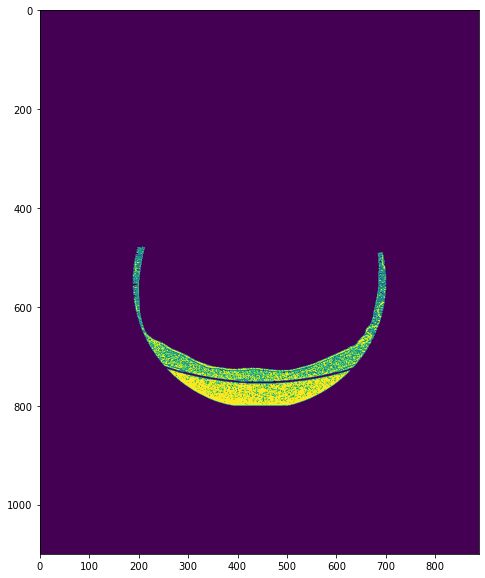

1


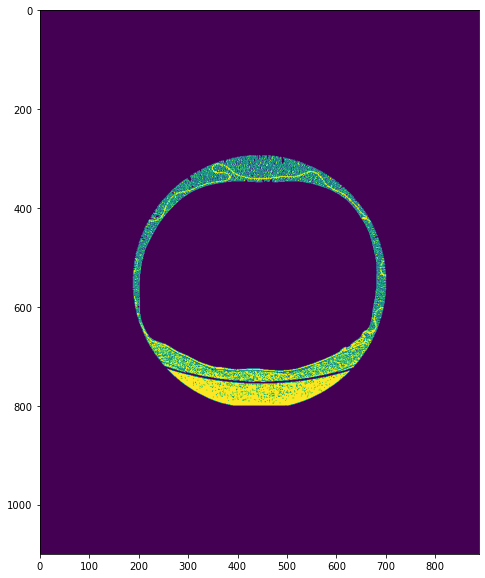

2


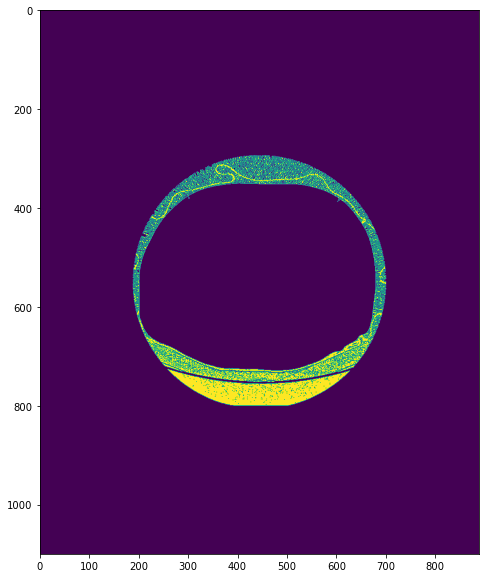

3


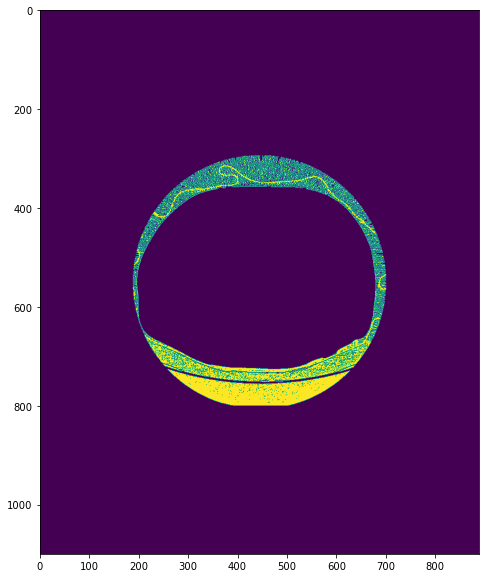

4


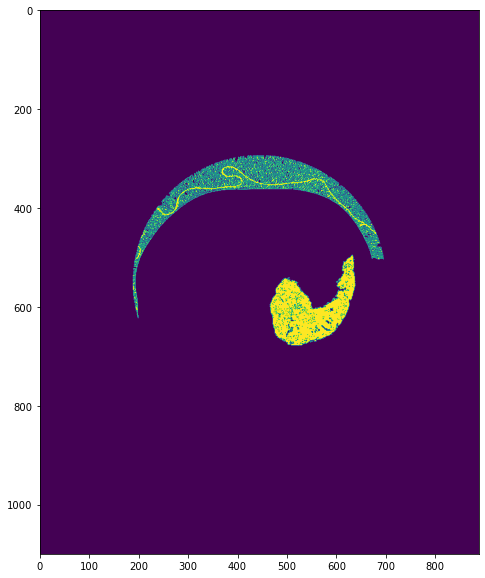

5


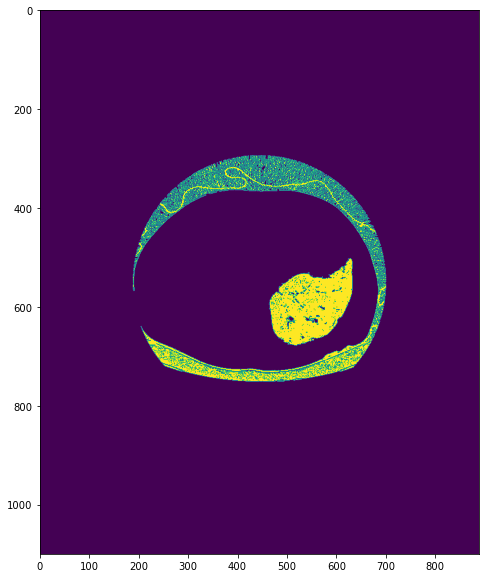

6


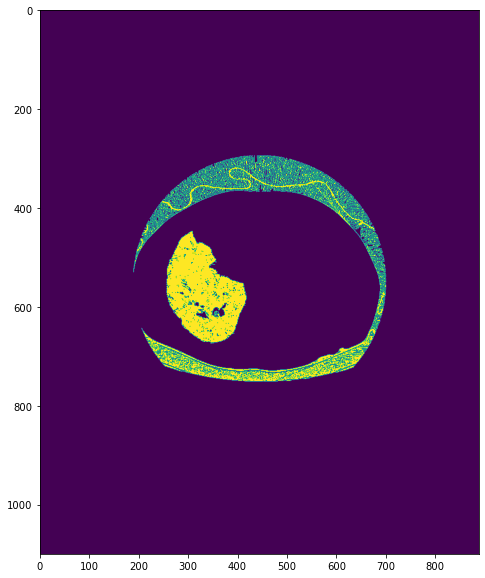

7


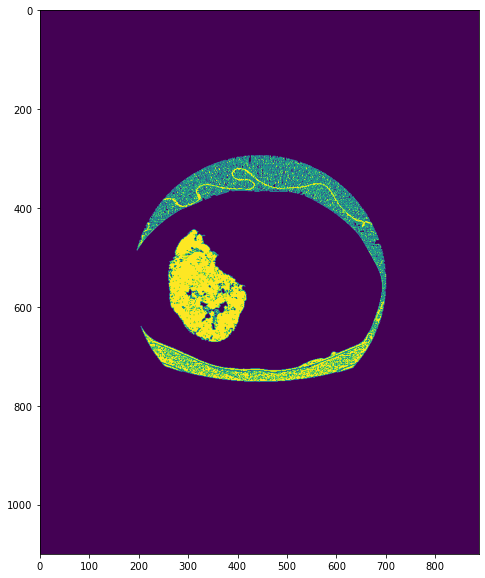

8


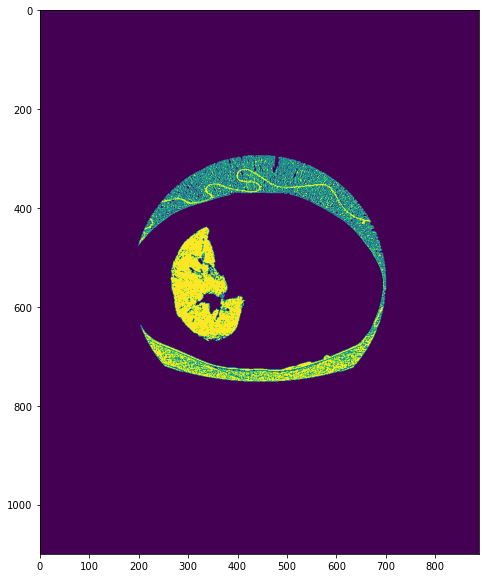

9


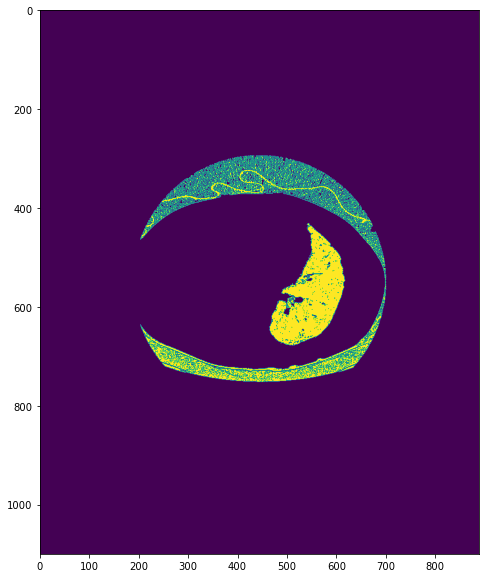

10


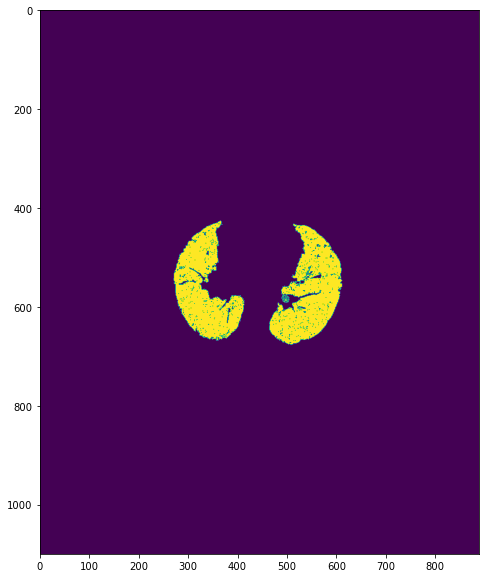

11


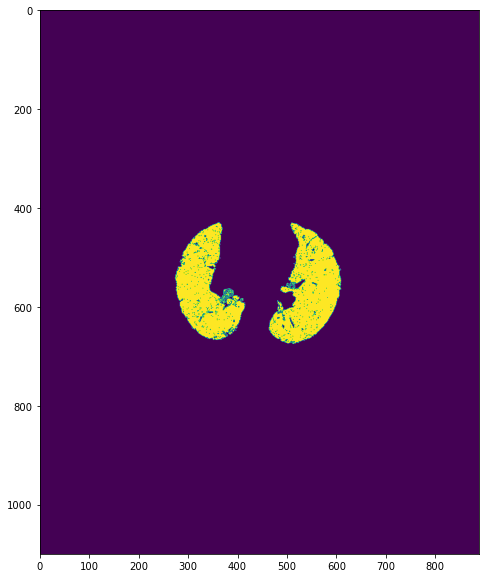

12


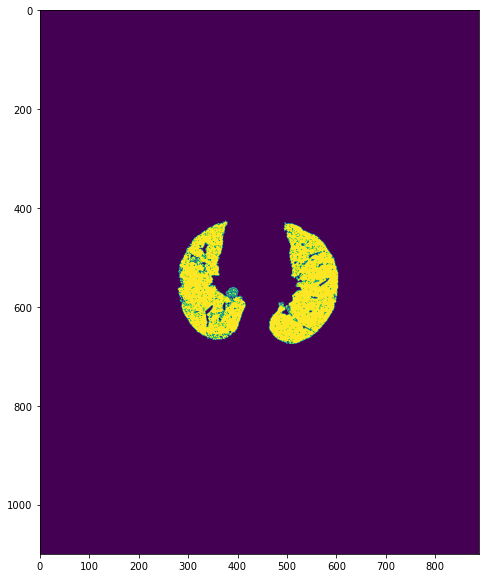

13


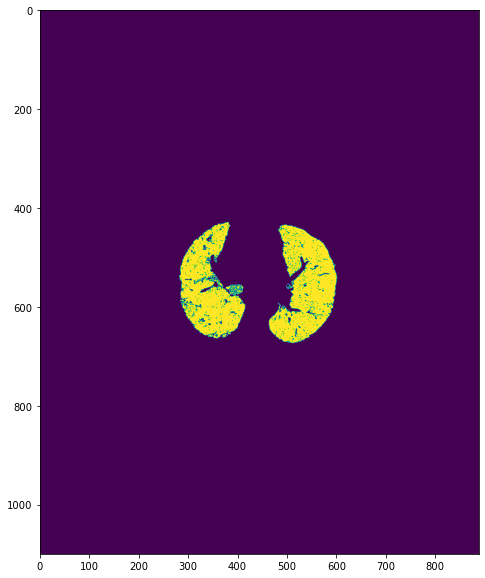

14


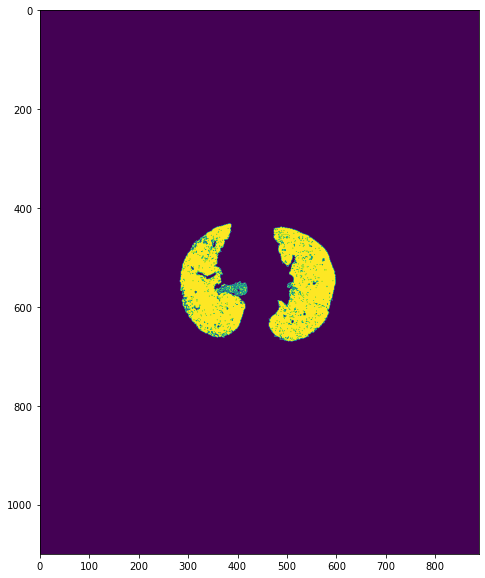

15


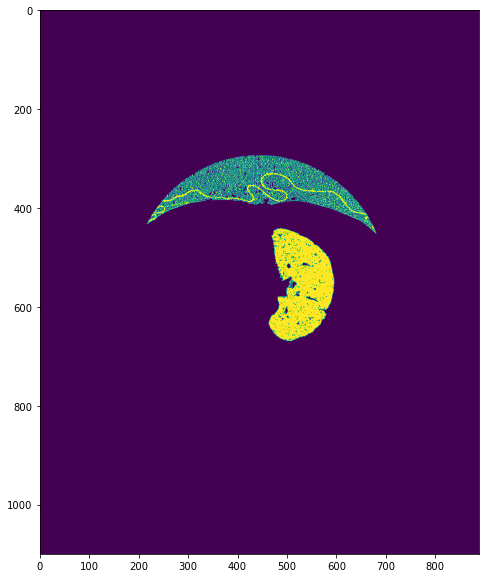

16


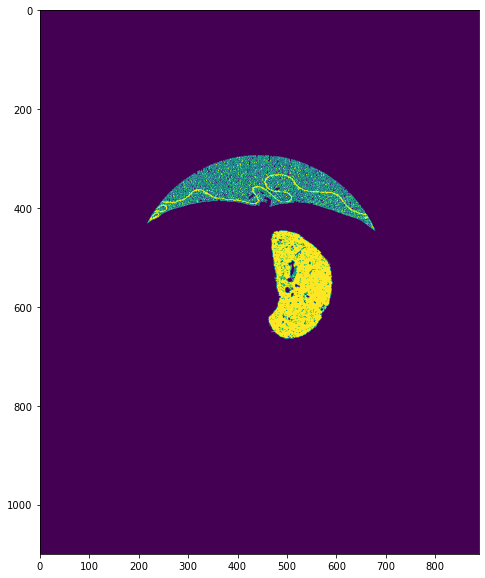

17


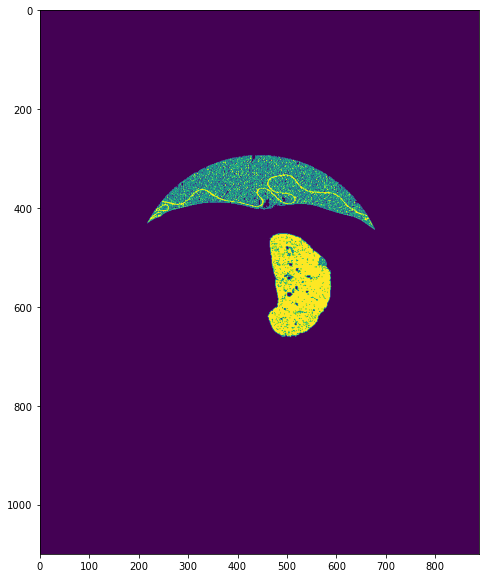

18


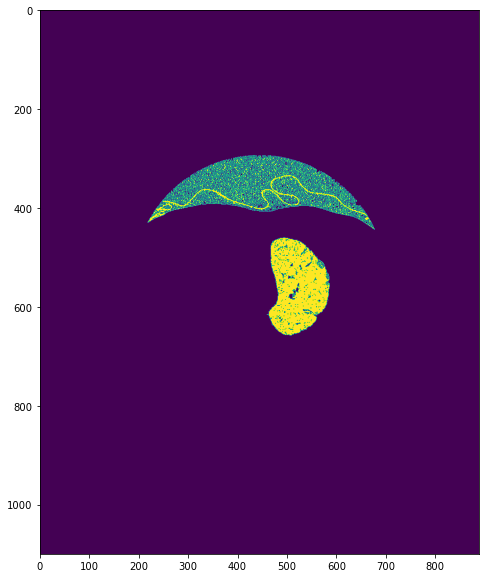

19


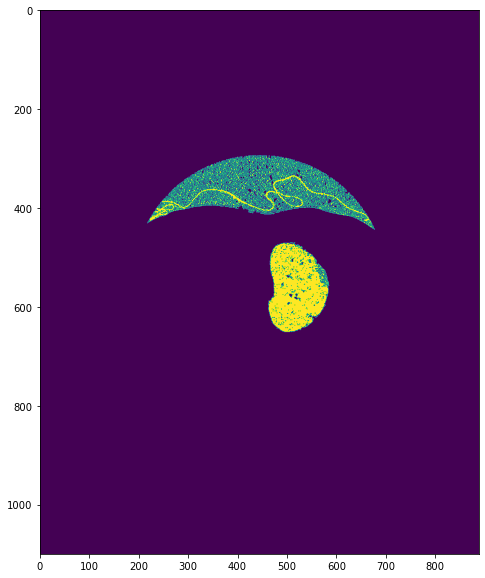

20


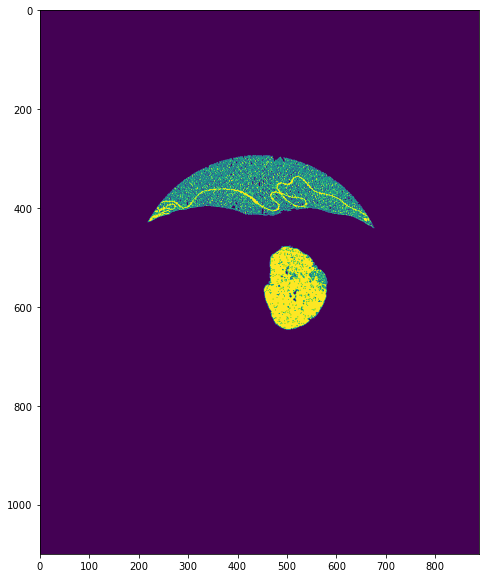

21


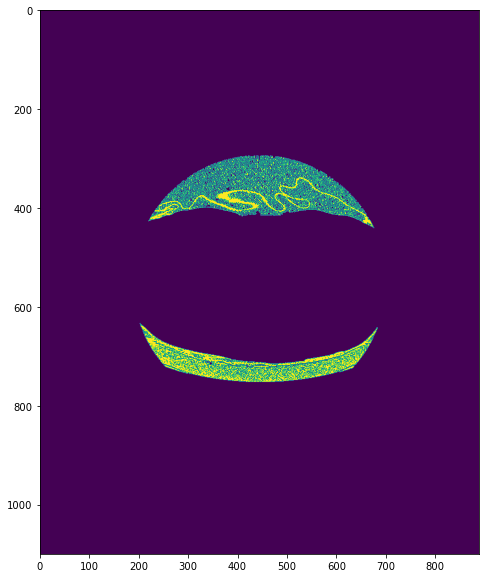

22


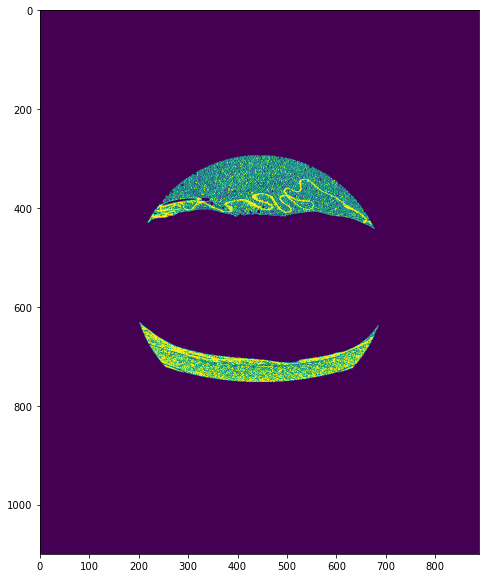

23


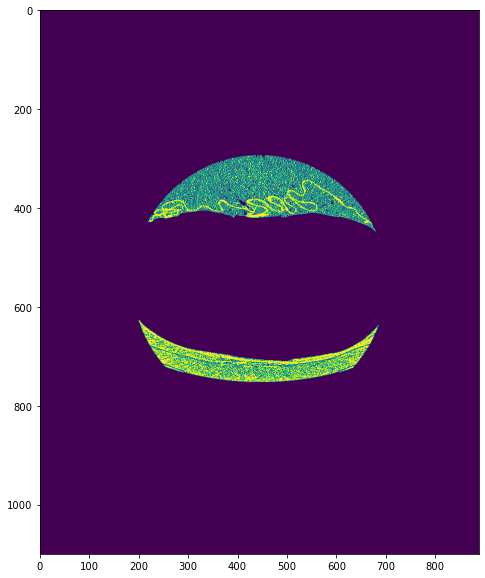

24


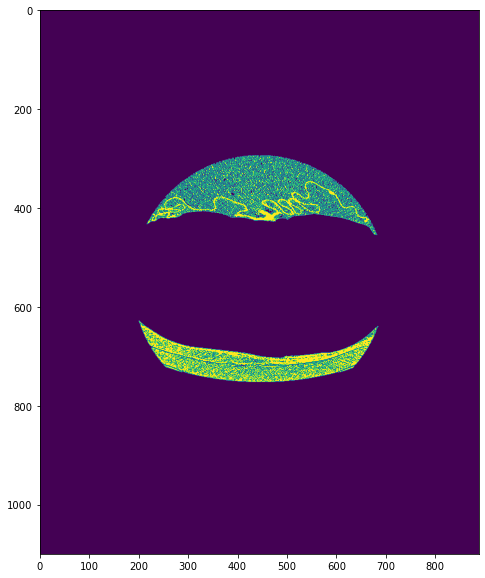

25


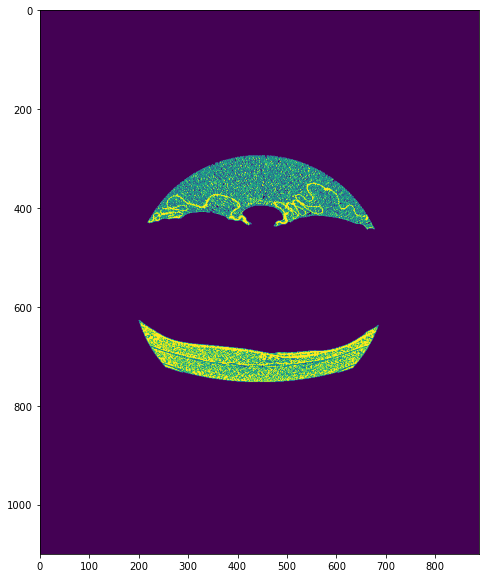

26


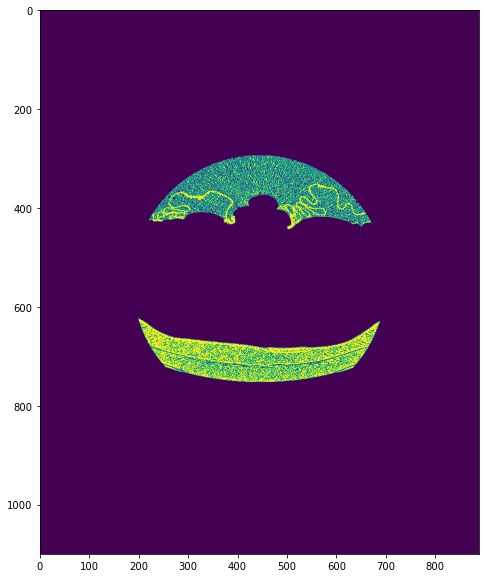

27


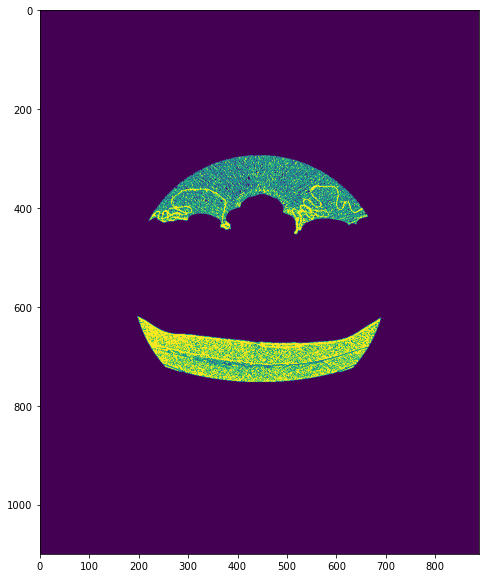

In [91]:
for i in range(0,len(mask), 1):
    print(i)
    plt.figure(figsize=(10,10))
    plt.imshow(mask[i])
    plt.show()

##### exclusion_list

In [310]:
def crop_center(slice, cropx, cropy, save_origin_sz=True, fill_value=0):
    '''
    cropx [mm]
    cropy [mm]
    '''
    
    img = slice.pixel_array
    cropx = int(cropx/slice.PixelSpacing[0])
    cropy = int(cropy/slice.PixelSpacing[0])
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    
    if save_origin_sz:
        result = np.zeros_like(img)+fill_value
        result[starty:starty+cropy, startx:startx+cropx] =\
        img[starty:starty+cropy, startx:startx+cropx]

        return result
    else:
        return img[starty:starty+cropy, startx:startx+cropx]

In [311]:
slices[0].pixel_array.shape

(512, 512)

In [312]:
croped = crop_center(slices[0], 310, 250, save_origin_sz=True, fill_value=0)

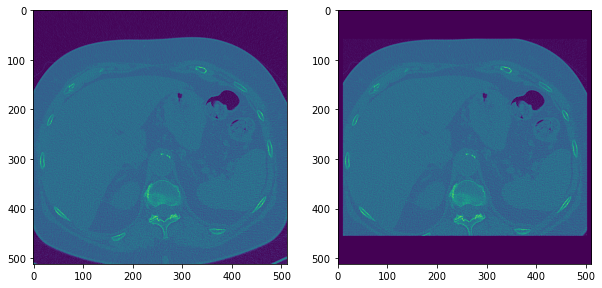

In [313]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(slices[0].pixel_array)

plt.subplot(1,2,2)
plt.imshow(croped)
plt.show()

In [314]:
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

for s in slices:
    s.SliceThickness = slice_thickness

In [315]:
def crop_center_z(slices, cropz):
    a = np.arange(len(slices))
    slice_thickness = slices[0].SliceThickness
    print(slice_thickness)
    cropz = int(cropz/slice_thickness)
    startz = len(slices)//2 - cropz//2
    print(startz, startz+cropz)
    return a[startz:startz+cropz]

In [316]:
slices = crop_center_z(slices, 50)

1.0
64 114


In [ ]:
slices

In [320]:
len(slices)

178

In [268]:
slices[0].SliceThickness

"1.0"

In [54]:
slices[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.118599980507060671445324091215207081553
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0018) SOP Instance UID                    UI: 2.25.118599980507060671445324091215207081553
(0008, 0060) Modality                            CS: '

In [207]:
512*0.62890625

322.0

In [229]:
400/0.62890625

636.0248447204968

In [ ]:
400 300 400

In [325]:
ex = np.array(['ID00132637202222178761324',
 'ID00026637202179561894768',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00011637202177653955184',
 'ID00128637202219474716089'])

In [326]:
np.unique(ex)

array(['ID00011637202177653955184', 'ID00026637202179561894768',
       'ID00128637202219474716089', 'ID00132637202222178761324'],
      dtype='<U25')